# Automating the Cybersecurity Triage Process: A Comparative Study on the Performance of Large Language Models

Install required libraries, including OpenAI and Ollama

In [ ]:
!pip install openai
!pip install ollama
!pip install pandas
!pip install openpyxl
!pip install matplotlib

Import libraries

In [20]:
import os
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
from statistics import median
from abc import abstractmethod, ABC
from typing import Any
from openai import AzureOpenAI
from ollama import Client

Define Abstraction Class for Language Models and Prompts.

In [3]:
class Prompt:

    def __init__(self, system: str, user: str):
        self.system = system
        self.user = user


class LanguageModel:

    def __init__(self, model_id: str):
        self.model_id = model_id

    @abstractmethod
    def generate(self, prompt: Prompt) -> dict[str, str]:
        pass


class PromptGenerator:

    @abstractmethod
    def generate(self, input_value: any) -> Prompt:
        pass

    @abstractmethod
    def get_id(self) -> str:
        pass

    @abstractmethod
    def get_field(self) -> str:
        pass


class JsonPromptGenerator(PromptGenerator, ABC):

    def __init__(self, data: dict[str, str]):
        self.data = data

    def get_field(self) -> str:
        return self.data['field']

    def get_id(self) -> str:
        return self.data['id']


def load_json(path: str) -> dict[str, Any]:
    with open(path, 'r') as f:
        return json.load(f)

Implement OpenAI Language Model.

In [4]:
OPENAI_KEY: str = os.getenv("OPENAI_KEY")
OPENAI_ENDPOINT: str = os.getenv("OPENAI_ENDPOINT")
OPENAI_DEPLOYMENT: str = os.getenv("OPENAI_DEPLOYMENT")


class OpenAILanguageModel(LanguageModel):
    client = AzureOpenAI(azure_endpoint=OPENAI_ENDPOINT, api_key=OPENAI_KEY, api_version="2024-02-15-preview")

    def generate(self, prompt: Prompt) -> dict[str, str]:
        try:
            t0 = time.time()
            response = OpenAILanguageModel.client.chat.completions.create(
                model=self.model_id,
                messages=[
                    {"role": "system", "content": prompt.system},
                    {"role": "user", "content": prompt.user},
                ],
                response_format={"type": "json_object"}
            )
            t1 = time.time()

            return {'response': response.choices[0].message.content,
                    'in_tokens': response.usage.prompt_tokens,
                    'out_tokens': response.usage.completion_tokens,
                    'time': t1 - t0}

        except Exception as e:
            return {'error': str(e)}

Implement Ollama Language Model.

**Note:** This requires Ollama to be running in the background on the address equal to `OLLAMA_HOST`.
This is done by executing `ollama serve`.

In [5]:
OLLAMA_HOST = 'http://localhost:11434'


class OllamaLanguageModel(LanguageModel):
    client = Client(host=OLLAMA_HOST)

    def generate(self, prompt: Prompt) -> dict[str, str]:
        try:
            t0 = time.time()
            result = OllamaLanguageModel.client \
                .generate(model=self.model_id,
                          system=prompt.system,
                          prompt=prompt.user,
                          format='json',
                          stream=False)
            # consider bug where repeated token limit is reached and output is aborted but not marked as done
            if result['done']:
                result['time'] = result['total_duration'] / 1e9
            else:
                result['time'] = time.time() - t0
            return result

        except Exception as e:
            return {'error': str(e)}

Create model clients.

**Note:** This script assumes that the Ollama models have already been pulled.

In [6]:
models: dict[str, LanguageModel] = {
    'llama3': OllamaLanguageModel('llama3:8b'),  # 8b
    'phi3': OllamaLanguageModel('phi3:14b'),  # 14b
    'phi3-mini': OllamaLanguageModel('phi3:3.8b'),  # 3.8b
    'aya23': OllamaLanguageModel('aya:8b'),  # 8b
    'mistral': OllamaLanguageModel('mistral:7b'),  # 7b
    'codellama': OllamaLanguageModel('codellama:13b'),  # 7b
    'gemma': OllamaLanguageModel('gemma:7b'),  # 7b
    'gemma-mini': OllamaLanguageModel('gemma:2b'),  # 2b
    'gpt4': OpenAILanguageModel(OPENAI_DEPLOYMENT),  # 1760b
}

Setup evaluation framework

In [81]:
def parse_model_response(response: str, field: str) -> bool | None:
    """
    Parse the JSON output of a language model and return True or False depending on the answer.
    Incorrect JSON syntax will return False.
    :param response: The JSON output of a language model.
    :param field: The JSON key that contains the boolean value.
    :return: True or False.
    """
    try:
        return json.loads(response)[field]
    except (TypeError, KeyError) as _:
        return None


def execute_all_on_model(model: LanguageModel, prompts: list[Prompt], delay: int = 0) -> list[dict[str, str]]:
    result = []
    first_run = True
    for prompt in prompts:
        if not first_run:
            time.sleep(delay)
            first_run = False
        result.append(model.generate(prompt))  # execute prompt
    return result


def generate_prompts(prompt_generator: PromptGenerator, input_values: list[str]) -> list[Prompt]:
    return [prompt_generator.generate(value) for value in input_values]


def evaluate_model_outputs(predicted: list[bool], actual: list[bool]) -> dict[str, bool]:
    tp, tn, fp, fn = 0, 0, 0, 0
    for _p, _a in zip(predicted, actual):
        if _p and _a:
            tp += 1
        elif _p and not _a:
            fp += 1
        elif not _p and _a:
            fn += 1
        elif not _p and not _a:
            tn += 1
    return {'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}


def get_evaluation_statistics(evaluation: dict[str, int]) -> dict[str, float]:
    tp, tn, fp, fn = evaluation['tp'], evaluation['tn'], evaluation['fp'], evaluation['fn']
    accuracy = 0.0 if sum((tp, tn, fp, fn)) == 0 else (tp + tn) / (tp + tn + fp + fn)
    precision = 0.0 if tp == 0 else tp / (tp + fp)
    recall = 0.0 if tp == 0 else tp / (tp + fn)
    f1 = 0.0 if tp == 0 else 2 * precision * recall / (precision + recall)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


def get_model_responses(outputs: list[dict[str, str]]) -> list[str]:
    return [output['response'] for output in outputs if 'response' in output]


def run_evaluation(model: LanguageModel,
                   prompts: list[Prompt],
                   classifications: list[bool],
                   field: str,
                   delay: int = 0) -> dict[str, float]:
    outputs: list[dict[str, str]] = execute_all_on_model(model, prompts, delay)
    median_time = median(o['time'] for o in outputs if 'time' in o)
    responses = get_model_responses(outputs)
    parsed_raw = [parse_model_response(response, field) for response in responses]
    errors = len([p for p in parsed_raw if p is None])
    parsed = [p for p in parsed_raw if p is not None]
    evaluation = evaluate_model_outputs(parsed, classifications)
    statistics = get_evaluation_statistics(evaluation)
    statistics['time'] = median_time
    statistics['errors'] = errors
    return statistics | evaluation


def evaluate_all_models(language_models: dict[str, LanguageModel],
                        prompt_generators: dict[str, PromptGenerator],
                        dataset: tuple[list[str], list[bool]],
                        delay: int = 0) -> dict[str, dict[str, dict[str, float]]]:
    prompts_dict: dict[str, list[Prompt]] = {
        key: generate_prompts(generator, dataset[0])
        for key, generator in prompt_generators.items()
    }

    nested: dict[str, dict[str, dict[str, float]]] = dict()

    for model_id, model in language_models.items():
        print(model_id)
        model_result = dict()
        nested[model_id] = model_result
        first_run = True
        for prompt_id, prompts in prompts_dict.items():
            print('\t' + prompt_id)
            if not first_run:  # wait between prompt runs
                time.sleep(delay)
                first_run = False
            evaluation = run_evaluation(model, prompts, dataset[1], prompt_generators[prompt_id].get_field())
            print('\t\t' + str(evaluation))
            model_result[prompt_id] = evaluation

    return nested


def transform_evaluation(nested: dict[str, dict[str, dict[str, float]]]) -> pd.DataFrame:
    df = pd.DataFrame.from_dict(nested, orient='index').stack().to_frame()
    return pd.DataFrame(df[0].values.tolist(), index=df.index)


## Detect Email Announcements



In [65]:
class DetectAnnouncementPrompt(JsonPromptGenerator):

    def generate(self, email: str) -> Prompt:
        return Prompt(self.data['system'], self.data['user'] + '\n' + email)


detect_email_announcement_prompts: dict[str, PromptGenerator] = {
    key: DetectAnnouncementPrompt(value)
    for key, value in load_json('data/detect_announcement_prompts.json').items()
}

Get announcement email dataset.

In [9]:
announcement_emails = pd.read_excel('data/announcement_emails.xlsx') \
    .rename(columns={'cleaned_email_body': 'email'})[['email']]
announcement_emails['is_announcement'] = True
announcement_emails

,email,is_announcement
0,name13 will be working on AZWEU-OLSTB01 today....,True
1,We will add the user name15 as a owner to the ...,True
2,name16 will use his admin account (Ka6053adm) ...,True
3,We did some testing on the SRV602 with discove...,True
4,name1 applied the scheduled task to the SVR-ND...,True
5,name2 just created an external mail forwarding...,True
6,name3 be loggin in on the VM-DCS-01 with my Ex...,True
7,customer3 announced that the user 'jedox-power...,True
8,name4 will add the user Jayy.Watson01 to the b...,True
9,customer5 will add the user “sea_line” to the ...,True


Get normal emails from Enron dataset.

In [10]:
normal_emails = pd.read_csv('data/enron.csv', nrows=500) \
    .rename(columns={'Message': 'email'})[['email']]
normal_emails_sizes = normal_emails['email'].map(len)  # get email sizes
normal_emails = normal_emails[(normal_emails_sizes > 100) & (normal_emails_sizes < 500)] \
    .sample(20)  # filter by email size and select 20
normal_emails['is_announcement'] = False
normal_emails

,email,is_announcement
261,"Julie,\n\n The numbers for January are below:\...",False
289,"Jim,\n\nIs there going to be a conference call...",False
294,"Alan, \n\nYou should have received updated num...",False
14,"Dave, \n\n Here are the names of the west desk...",False
307,I just spoke to the insurance company. They a...,False
165,"Lucy,\n\n I want to speak to Wade myself. He ...",False
355,"Larry,\n\nJacques has sent a document to Claud...",False
491,"George,\n\nWe should hear from the bank in Hou...",False
473,---------------------- Forwarded by Phillip K ...,False
313,"Andrea,\n\nAfter reviewing Bryan Hull's resume...",False


Concatenate the announcement and non-announcement datasets.

In [11]:
emails = pd.concat([announcement_emails, normal_emails]).sample(frac=1).reset_index(drop=True)
emails

,email,is_announcement
0,I will be scanning this issue on our AD/ ADCS ...,True
1,We will create two groups:\nLG_ADMIN-NLD-CIT-S...,True
2,"Jim,\n\nIs there going to be a conference call...",False
3,---------------------- Forwarded by Phillip K ...,False
4,can you build something to look at historical ...,False
5,"Larry,\n\nJacques has sent a document to Claud...",False
6,"Cooper,\n\nThis is the website I use:\n\nhttp:...",False
7,"Hi,\n\nFYI iam changing some membership in hig...",True
8,"Lucy,\n\nI got your email. I didn't have time...",False
9,custome10 is going to add account ‘svc_bck_dc@...,True


Split into dataset for prediction and actual classification.

In [ ]:
email_bodies: list[str] = [*emails['email'].values][0:1]
is_actual_announcement: list[bool] = [*emails['is_announcement'].values][0:1]
detect_announcement_dataset = (email_bodies, is_actual_announcement)

Run all prompts on all models.

In [66]:
announcement_detection_evaluation_dict = evaluate_all_models(
    {i: models[i] for i in models if i != 'gpt4'},
    detect_email_announcement_prompts,
    detect_announcement_dataset
)

llama3
	long
		{'accuracy': 0.95, 'precision': 0.95, 'recall': 0.95, 'f1': 0.9500000000000001, 'time': 0.6334123, 'errors': 0, 'tp': 19, 'tn': 19, 'fp': 1, 'fn': 1}
	short
		{'accuracy': 0.825, 'precision': 0.8095238095238095, 'recall': 0.85, 'f1': 0.8292682926829269, 'time': 0.6472122499999999, 'errors': 0, 'tp': 17, 'tn': 16, 'fp': 4, 'fn': 3}
phi3
	long
		{'accuracy': 0.6666666666666666, 'precision': 0.6666666666666666, 'recall': 0.5882352941176471, 'f1': 0.625, 'time': 2.9068880999999998, 'errors': 4, 'tp': 10, 'tn': 14, 'fp': 5, 'fn': 7}
	short
		{'accuracy': 0.375, 'precision': 0.2857142857142857, 'recall': 0.2857142857142857, 'f1': 0.2857142857142857, 'time': 2.889226, 'errors': 24, 'tp': 2, 'tn': 4, 'fp': 5, 'fn': 5}
phi3-mini
	long
		{'accuracy': 0.95, 'precision': 1.0, 'recall': 0.9, 'f1': 0.9473684210526316, 'time': 0.8543130159378052, 'errors': 0, 'tp': 18, 'tn': 20, 'fp': 0, 'fn': 2}
	short
		{'accuracy': 0.675, 'precision': 0.8181818181818182, 'recall': 0.45, 'f1': 0.5806

In [84]:
announcement_detection_evaluation_dict_gpt4 = evaluate_all_models(
    {'gpt4': models['gpt4']},
    detect_email_announcement_prompts,
    detect_announcement_dataset,
    7  # seconds delay between prompts
)

gpt4
	long


KeyboardInterrupt: 

Transform output into dataframe.

In [67]:
announcement_detection_evaluation = transform_evaluation(
    announcement_detection_evaluation_dict | announcement_detection_evaluation_dict_gpt4
)
announcement_detection_evaluation.index = announcement_detection_evaluation.index.rename(['model', 'prompt'])

<Axes: ylabel='model'>

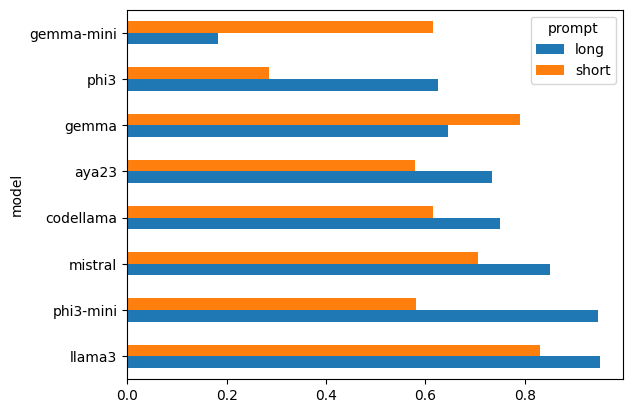

In [79]:
announcement_detection_f1 = announcement_detection_evaluation['f1']
announcement_detection_f1.unstack() \
    .sort_values(by=next(iter(detect_email_announcement_prompts.keys())), ascending=False) \
    .plot(kind='barh')